# CS 109A/AC 209A/STAT 121A Data Science: Homework 8
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 16th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW8.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import discriminant_analysis 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split as sk_split
import sklearn.neighbors as knn

%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a Extension

### Part (c): Who did you work with?

None

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Image Processing Revisited

In this problem we revisit applications of classification, with the purpose of comparing the performance of support vector classifiers with other classifiers we have learned. We'll begin with the aeriel vegetation detection problem from Homework #7.

The data is contained in `dataset_1.txt` and `dataset_2.txt` (you are encouraged to use the datasets from Homework #7 as well). The first two columns of the data contains the latitude and longitudes of randomly sampled locations in the satellite image, and the last column contains a label indicating whether the location contains vegetation (1 denotes the presence of vegetation and 0 denotes otherwise). The task is to, again, identify the vegetation regions in the image.

- Compare the result of using support vector classifiers to perform classification against results obtained from other models you have learned. Which model is more appropriate for the general task of vegetation detection in aerial images (do not restrict yourself to which model performs better on just these two datasets)? Which model is more appropriate for other types of image processing (hand-writting digit classification for example) Your comparison should be both **qualitative** and quantitative.

    **Hint:** For your analysis, it's vital to consider the differences between the ways in which each of these models perform classification. These differences can be gauged by looking at the differences between the decision boundaries drawn by the models and **how** these boundaries are determined. 
    
- Are there any obvious draw backs to support vector classifiers as we have presented them to you? What might be some intuitive ways to address these draw backs?

Again, we provide you with a function `plot_decision_boundary` to visualize the decision boundary of a classifier.

In [2]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white', marker='D', alpha=.5)

    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    
    # my mod from homework 7... though I may pull out the classification-via-linear-regression calls anyway
    # here is my attempt to get the linear model to classify, using the mean value
    #  of all the predicted values as the dividing line between classifying as 0 vs. 1
    # and I didn't want to add another param so I did the un-pythonic isinstance
    #  guess I could have skipped that and run any model through my code, 0 would still remain 0 and 1, 1
    if isinstance(model, linear_model.LinearRegression):    
        yy_mean = np.mean(yy)
        def f(x):
            return 0 if x < yy_mean else 1
        f = np.vectorize(f)
        yy = f(yy)

    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [3]:
# Load dataset_1 and take a look at both parts
data_1_train = pd.read_csv('datasets/dataset_1_train.txt', delimiter=',', header=None
                             ,names=['latitude','longitude','has_vegetation'])
print 'data_1_train has {} rows'.format(data_1_train.shape[0])
print data_1_train.head()

print
data_1_test = pd.read_csv('datasets/dataset_1_test.txt', delimiter=',', header=None
                             ,names=['latitude','longitude','has_vegetation'])
print 'data_1_test has {} rows'.format(data_1_test.shape[0])
print data_1_test.head()


data_1_train has 16 rows
   latitude  longitude  has_vegetation
0  0.678422   0.332760               0
1  0.446285   0.233264               0
2  0.502779   0.956748               1
3  0.615255   0.953660               1
4  0.043501   0.395151               1

data_1_test has 84 rows
   latitude  longitude  has_vegetation
0  0.280268   0.117105               0
1  0.988742   0.198253               0
2  0.727475   0.324033               0
3  0.770978   0.089050               0
4  0.345216   0.118948               0


In [4]:
# Load dataset_2 and take a look
data_2_train = pd.read_csv('datasets/dataset_2_train.txt', delimiter=',', header=None
                             ,names=['latitude','longitude','has_vegetation'])
print 'data_2_train has {} rows'.format(data_2_train.shape[0])
print data_2_train.head()

print
data_2_test = pd.read_csv('datasets/dataset_2_test.txt', delimiter=',', header=None
                             ,names=['latitude','longitude','has_vegetation'])
print 'data_2_test has {} rows'.format(data_2_test.shape[0])
print data_2_test.head()

data_2_train has 20 rows
   latitude  longitude  has_vegetation
0  0.444571   0.715747               1
1  0.502779   0.956748               1
2  0.615255   0.953660               1
3  0.101488   0.087256               0
4  0.043501   0.395151               1

data_2_test has 80 rows
   latitude  longitude  has_vegetation
0  0.280268   0.117105               0
1  0.988742   0.198253               0
2  0.678422   0.332760               0
3  0.727475   0.324033               0
4  0.770978   0.089050               0


Most striking thing after a quick look at the various datasets is both how small the training sets are in absolute size and how much larger the test sets are relative to those training sets. Normally we might expect somewhere between a 60/40 and 80/20 training/test split but the ratio is reversed here, more like 20/80 for dataset_1 and 25/75 for dataset_2. Perhaps necessary for illustrative aspects of this exercise but something to be very aware of in terms of expanding out to other datasets.

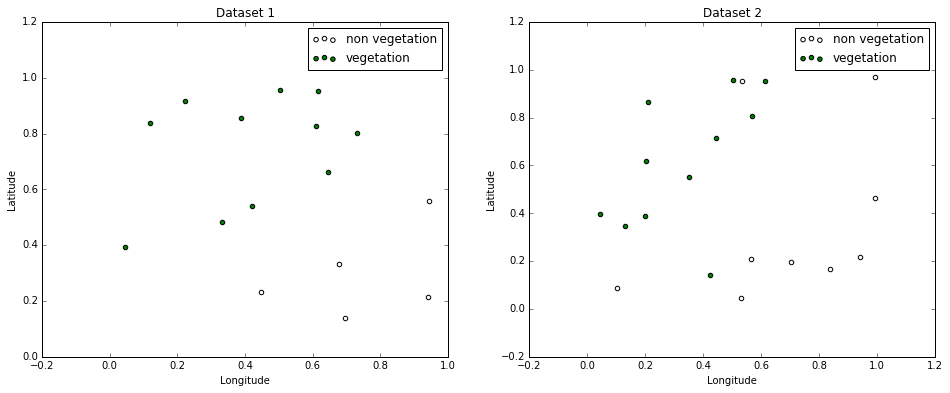

In [5]:
# Plot data
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

#Plot dataset 1
x = data_1_train.values[:, :-1]
y = data_1_train.values[:, -1]

ax[0].scatter(x[y==0, 0], x[y==0, 1], c='white', label='non vegetation')
ax[0].scatter(x[y==1, 0], x[y==1, 1], c='green', label='vegetation')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Dataset 1')
ax[0].legend(loc='best')

#Plot dataset 2
x = data_2_train.values[:, :-1]
y = data_2_train.values[:, -1]

ax[1].scatter(x[y==0, 0], x[y==0, 1], c='white', label='non vegetation')
ax[1].scatter(x[y==1, 0], x[y==1, 1], c='green', label='vegetation')

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Dataset 2')
ax[1].legend(loc='best')

plt.show()


One can easily image a straight line that will separate the two sets of points in Dataset 1. Guessing at a best-fit line for Dataset 2 would still result in at least one vegetation point in the non-vegetation space and also at least one non-vegetation point in what would be the area of vegetation. 

In [6]:
def plot_decision_boundary_and_sv(data, data_description):
    # Load dataset
    x = data.values[:, :-1]
    y = data.values[:, -1]

    # Fit SVM model with C = 1000, linear kernel
    model = svm.SVC(C=1000, kernel='linear')
    model.fit(x, y)

    # Plot decision boundary
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    ax[0] = plot_decision_boundary(x, y, model, '{} (train), fit with entire data'.format(data_description), ax[0])

    # Highlight the support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

    # Isolate only support vectors and their labels
    x_svs = x[sv_indices, :] 
    y_svs = y[sv_indices]
    model.fit(x_svs, y_svs)

    # Plot decision boundary with only support vectors
    ax[1] = plot_decision_boundary(x_svs, y_svs, model, '{} (train), refit with only SVs'.format(data_description), ax[1])

    # Highlight the support vectors
    ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return fig                


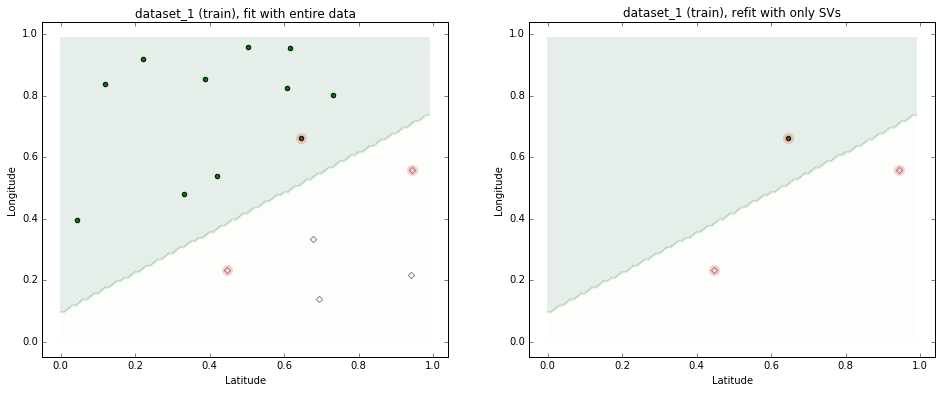

In [7]:
plot_decision_boundary_and_sv(data_1_train, 'dataset_1')
plt.show()

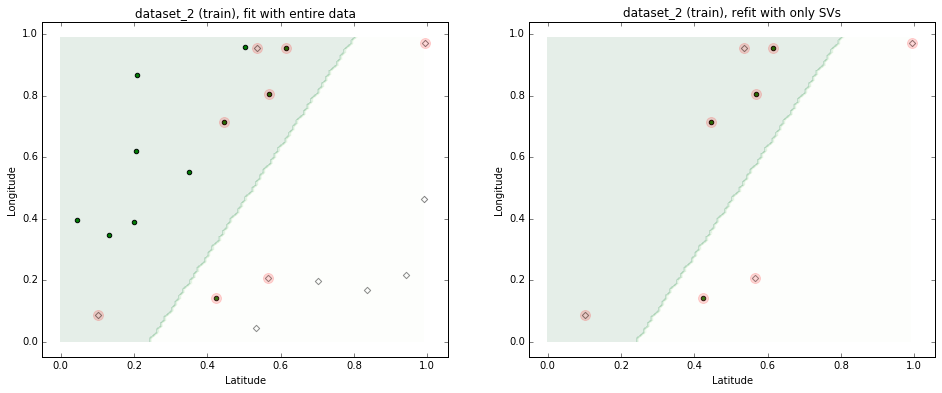

In [8]:
plot_decision_boundary_and_sv(data_2_train, 'dataset_2')
plt.show()

Now try to improve the model for dataset_2 by experimenting with classifier parameters.

In [9]:
#--------  fit_and_plot_svm_for_c
# Fit and plot SVM model for value of 'C', overlayed on a scatter plot of data 
# (fit on train set and evaluate on test set)
#
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses)#      
#      x_test (array of test predictors)
#      y_test (array of test responses)
#      bounds (tuple of bounds for plotting)
#      C  (value for parameter C)
#      ax (axes to plot on)

def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1)):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return ax

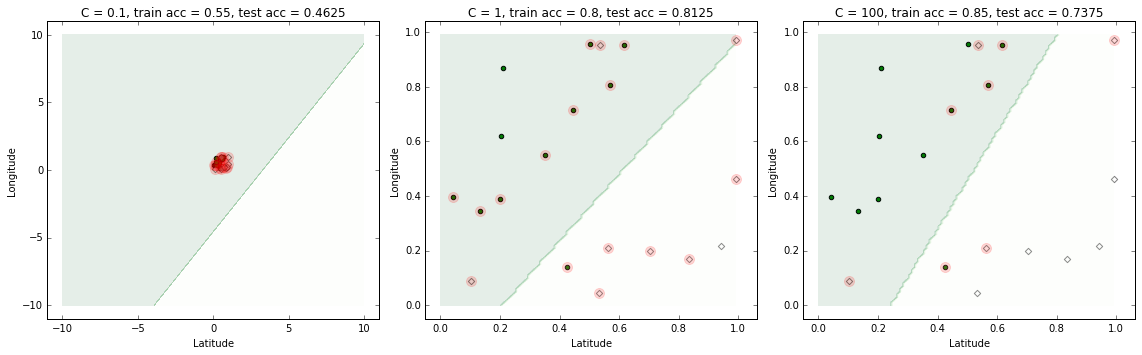

In [10]:
x_train = data_2_train.values[:, 0:-1]
y_train = data_2_train.values[:, -1]

x_test = data_2_test.values[:, 0:-1]
y_test = data_2_test.values[:, -1]

# Fit and plot for different 'C' values
fig, ax = plt.subplots(1, 3, figsize = (16, 5))

ax[0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 0.1, ax[0], (-10, 10))
ax[1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 1, ax[1])
ax[2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 100, ax[2])

plt.tight_layout()

Above tested some values of C, beginning with 0.1, meaning that accuracy isn't very important be we want maximal separation, all values wind up being categorized in same class, 'has vegatation' in this case. Then we increase C to 1 and get a reasonable decision boundary, in addition to increased test accuracy. Jumping up to C = 100 and we still get a decent looking decision boundary but testing accuracy decreases, due to overfitting. 
Let's try to do a little better by running through some C values on either side of 1.

In [11]:
# iterate through some further C inputs for dataset 2 and report testing accuracy
c_values = [0.25, 0.5, 0.75, 0.85, 1, 5, 7, 15, 20, 25]
accs = np.zeros([len(c_values), 1])

print 'C\ttesting accuracy'
for C in c_values:

    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    print '{}\t{}'.format(C, ts_acc)

C	testing accuracy
0.25	0.4625
0.5	0.7
0.75	0.775
0.85	0.8
1	0.8125
5	0.8
7	0.8125
15	0.8375
20	0.825
25	0.825


Interesting to see the testing set accuracy bounce around a bit, with C=15 resulting in the higest accuracy. I suspect the rather small size of the training set might have something to do with that.

C=15, line doesnt look too different from C=1 and C=100, appears to hit the top x-axis about 1/2 way between 
 where those two were drawing the dividing line.


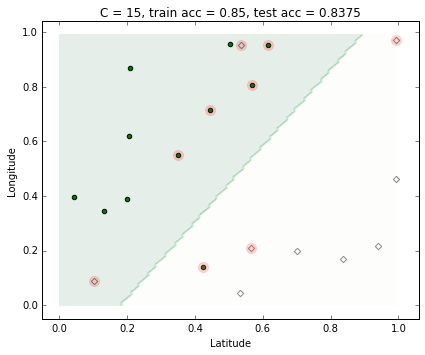

In [12]:
# C = 15, the best test accuracy from my attempts above
print 'C=15, line doesn''t look too different from C=1 and C=100, appears to hit the top x-axis about 1/2 way between '
print ' where those two were drawing the dividing line.'
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
ax = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 15, ax)
plt.tight_layout()

---

In [13]:
# below is from my homework 7, updated to receive different sets of data & report accuracy

def boundary_plots_from_model(sat_images, model, title_prefix, shift_bounds=False, poly_flag=False):
    
    dataset_count = len(sat_images)
    #Plot the data in each dataframe as a subplot of a single figure
    width = dataset_count * 6
    height = width/5 + 2
    fig, ax = plt.subplots(1, dataset_count, figsize=(width, height))

    fig.suptitle(title_prefix, fontsize=20, y=1.02, x=0.2)
    
    #Iterate through the dataframes
    for i in range(dataset_count):
        
        sat_images_train = sat_images[i][0]
        sat_images_test = sat_images[i][1]
        
        #Get the long/lat coords
        x_train = sat_images_train.values[:, :-1]
        #Get the class labels
        y_train = sat_images_train.values[:, -1]    
        #Samee for test
        x_test = sat_images_test.values[:, :-1]
        y_test = sat_images_test.values[:, -1]    
        
        if poly_flag:
            #Expand our predictor array with quadratic terms
            quad_features = preprocessing.PolynomialFeatures(degree = 2)
            x_train_expanded = quad_features.fit_transform(x_train)
            #Fit model with quadratic decision boundary
            model.fit(x_train_expanded, y_train)
            
            x_test_expanded = quad_features.fit_transform(x_test)
            model_score_train = model.score(x_train_expanded, y_train)
            model_score_test = model.score(x_test_expanded, y_test)
            
        else:
            #Fit non-quadratic model
            model.fit(x_train, y_train)
            model_score_train = model.score(x_train, y_train)
            model_score_test = model.score(x_test, y_test)
 
    
        #Change the bounds on the scatter plot (for HW 7 the 4th dataframe needs a larger frame)
        if i == 3 and shift_bounds:
            bounds = (-0.5, 1.5)
        else:
            bounds = (0, 1)

            
        title = 'sat image {}, train acc = {:.2}, test acc = {:.2}'.format(i + 1, model_score_train, model_score_test)
        #Plot the data along with the decision boundary learned by our model
        ax[i] = plot_decision_boundary(x_train, y_train, model, 
                                       title, 
                                       ax[i], bounds, poly_flag)
        
    return fig



plt.show()


In [14]:
# prep our datasets
np.random.seed(109)
hw7_sat_images = []
for i in range(1,5):
    dataset = pd.read_csv('datasets/dataset_{}.txt'.format(i), delimiter=',', header=None)
    # these came in as full datasets, split train/test at 70/30 for accuracy scores
    train, test = sk_split(dataset, test_size=0.30)
    hw7_sat_images.append([train, test])

hw8_sat_images = [[data_1_train, data_1_test], [data_2_train, data_2_test]]


Decision boundaries for various models, green shading indicates model will classify any point in that region as 
 being vegetation.


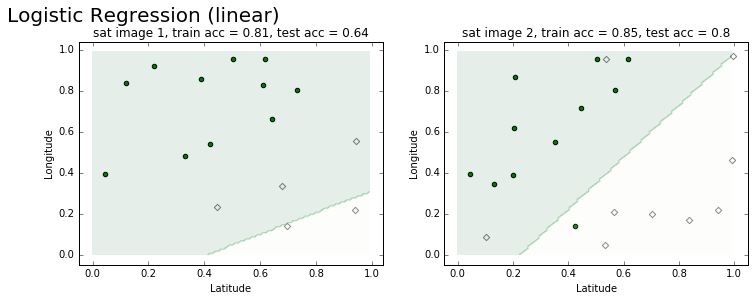

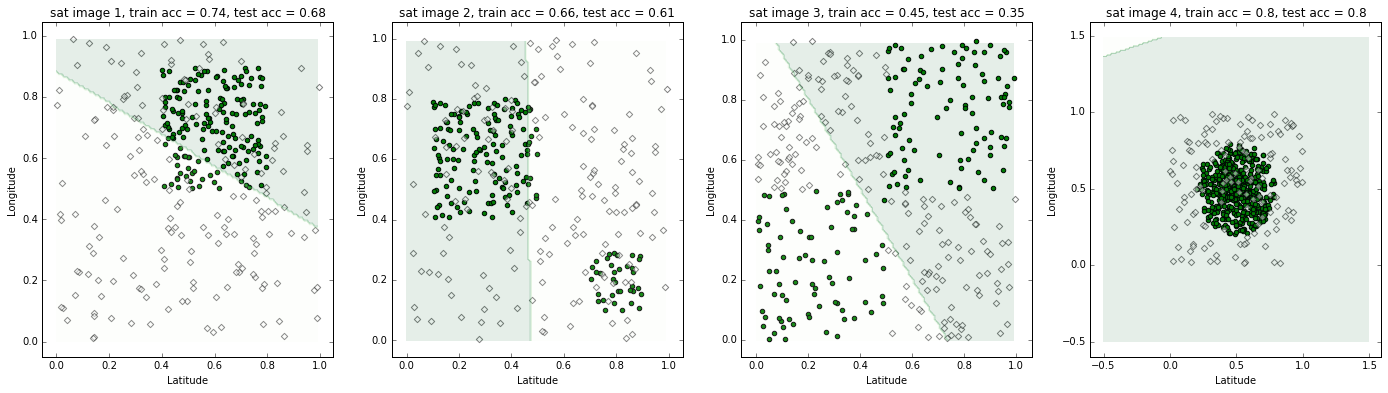

In [15]:
# run the two datasets through the same code I used for Homework 7, adjusted slightly for dataset enumeration
# begin with Logistic regression and then different cell/output fo reach model
print 'Decision boundaries for various models, green shading indicates model will classify any point in that region as '
print ' being vegetation.'

# the first two, the linear regression ones, have been forced into classifiers by comparing predictions vs. datset mean
# skipping these two for HW8, unless I have time to re-visit and truly evaluate my methodology for performing classification
#linreg1 = linear_model.LinearRegression()
#boundary_plots_from_model(sat_images, linreg1, 'Linear Regression        ')
#linreg2 = linear_model.LinearRegression()
#boundary_plots_from_model(sat_images, linreg2, 'Linear Polynomial Regression', poly_flag=True)

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()
# first the two datasets from this homework
boundary_plots_from_model(hw8_sat_images, logreg, 'Logistic Regression (linear)', shift_bounds=True)
# now the earlier ones
boundary_plots_from_model(hw7_sat_images, logreg, '', shift_bounds=True)

plt.show()

#### Logistic Regression
Attempts to model the conditional distribution of Y (is vegetation) given X (predictors made of of latitude and longitude values). Only really has an acceptable test accuracy on the two sparse datasets from this HW. Even there, I'm not sure why it wasn't able to better on the top left image, which SVM handled quite well. With the pure linear aspect, won't be able to do well unless the data is well separated into two sections before hand - even when there are distinct clusters as seen in the HW 7 images, a straight line can only do so well. One advantage of LR is that storage needs are minimal, only need the model's intercept and coefficient(s) to encode the prediction. Computationally it is in the middle somewhere, not as expensive as KNN but not as quick as LDA, once there is a model only need to do some quick np.dot multiplication to make the predictions. The decision boundary reflects the point at which a coordinate is equally as likely to be vegetation as not, that inflection point could be changed to increase/decrease the pivot point such that if we have some kind of bayesian prior information that vegetation is less likely (e.g. the points are at a higher than average altitiude), the predictions will take that into account and decrease likelhood of predicting vegetation

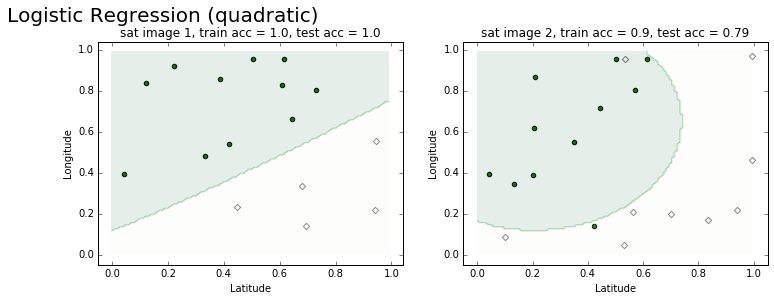

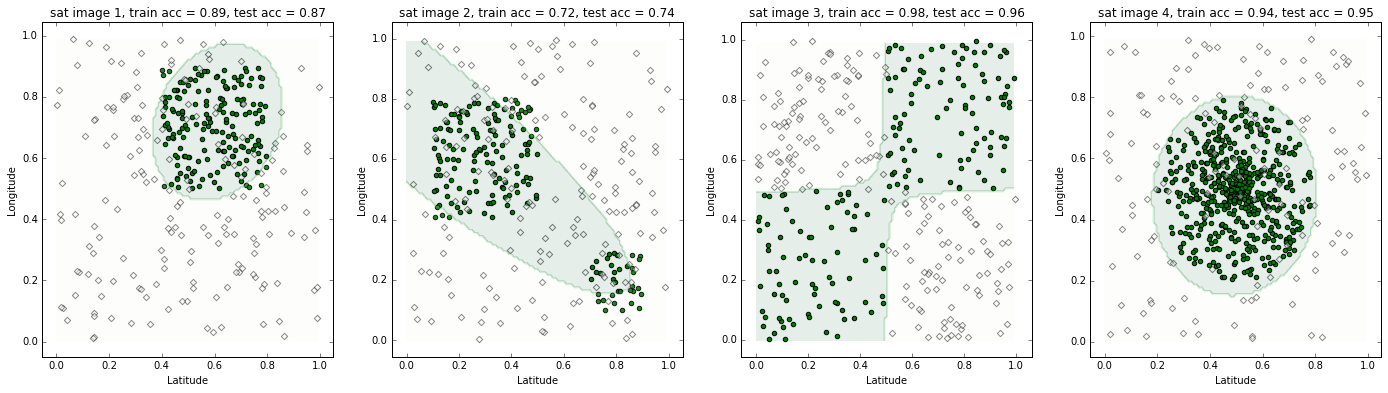

In [16]:

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)
boundary_plots_from_model(hw8_sat_images, logreg_poly, 'Logistic Regression (quadratic)', poly_flag=True)
boundary_plots_from_model(hw7_sat_images, logreg_poly, '', poly_flag=True)

plt.show()

#### Linear Regression with quadratic effects
Once we are able to modify the logistic regression to include quadratic terms and introduce curves we are able to get some good to very good test accuracy scores. In image 2 of HW7 the lack of contiguous is-vegetation coordinates leads to a relatively poor score. Beyond that, most of what was said earlier about linear logistic regression will still hold here, though computation costs will increase somewhat due to additional mathematical operations. Similarly storage needs will increase a bit as there are more coefficents, but overall the needs are still minimal.


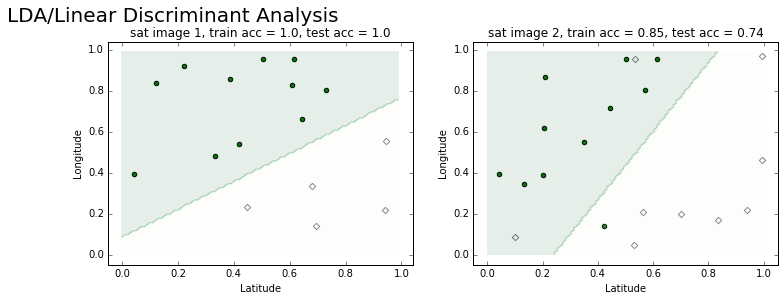

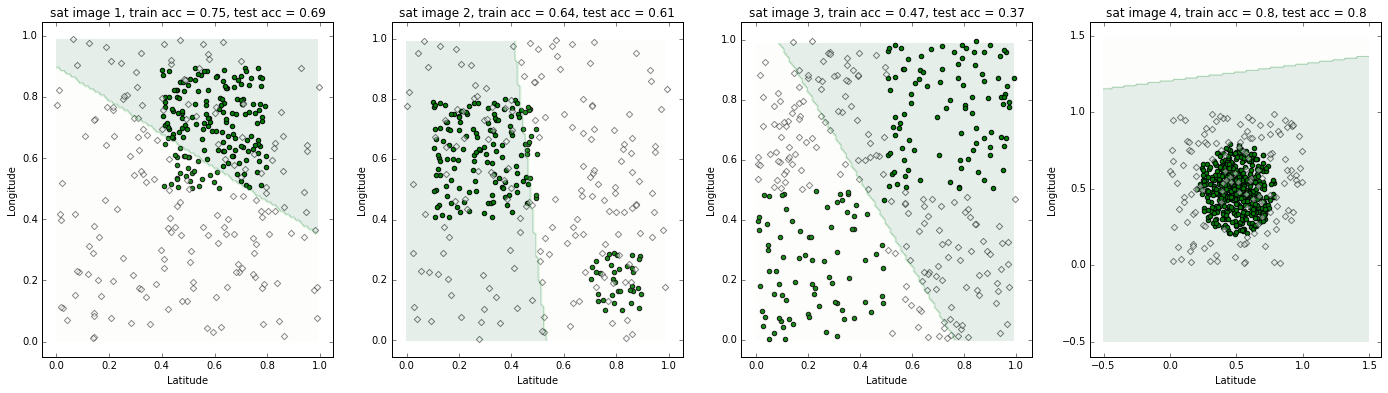

In [17]:
# LDA
lda = discriminant_analysis.LinearDiscriminantAnalysis()
boundary_plots_from_model(hw8_sat_images, lda, 'LDA/Linear Discriminant Analysis', shift_bounds=True)
boundary_plots_from_model(hw7_sat_images, lda, '', shift_bounds=True)

plt.show()

#### Linear Discriminant Analysis
Instead of first looking at the distribution of Y (is/is not vegetation) an LDA model tries to estimate the distribution of predictors (latitude, longitude) within each of the is/is not vegetation classes. The goal is to find a model that maximizes separation between those two classes. If there is just as much vegetation as not, and this is the expected condition, can proceed directly. Else, we may want to set priors that either approximate the proportion of classes in the dataset, or use some prior knowledge we might have (e.g. higher altitude means less vegetation). The above results look merely adequate, generally on par with logistic regression. In terms of storage needs, that is little more than the intercept & coefficients as with logistic regression + some info on the estimates of the data distribution, i.e. variance and mean. Computationally, LDA (& QDA, next) are some of the fastest performers and can be the logical choice with very large datasets. If the dataset is especially small, LDA may be preferred over QDA as the latter would have a tendency to overfit.


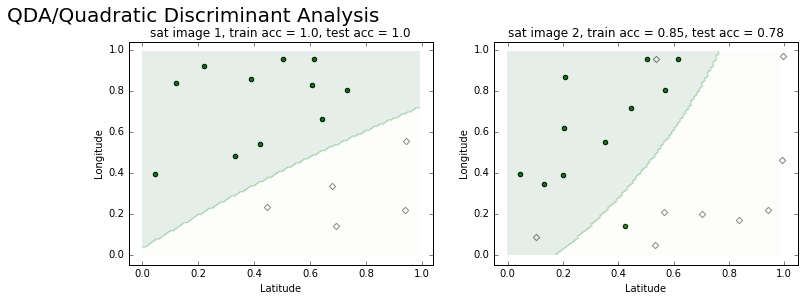

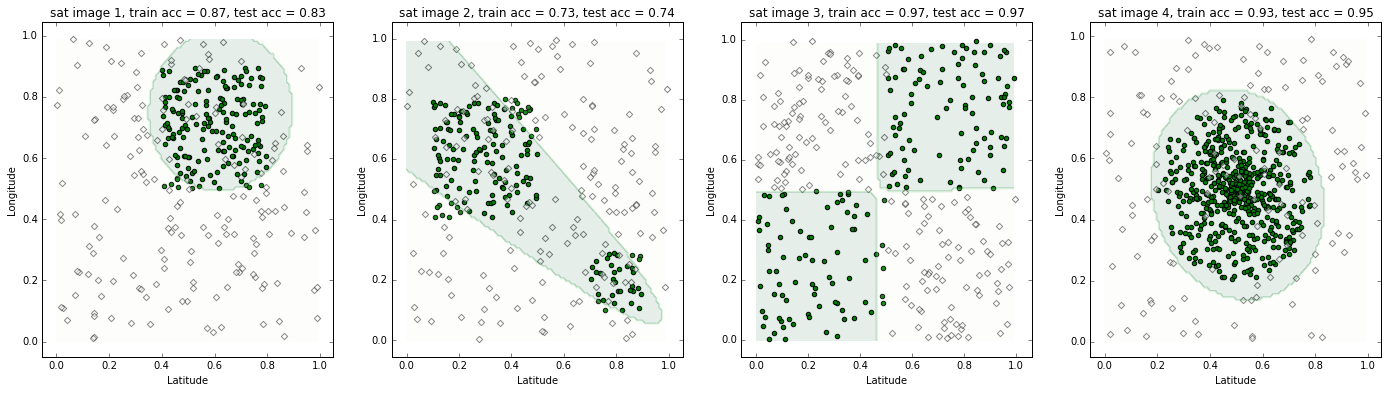

In [18]:
#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
boundary_plots_from_model(hw8_sat_images, qda, 'QDA/Quadratic Discriminant Analysis')
boundary_plots_from_model(hw7_sat_images, qda, '')

plt.show()

#### Quadratic Discriminant Analysis

QDA had among the best accuracy scores on the HW7 images, with an advantage over other approaches that were similary effective (i.e. logistic regression w/quadratic & decision trees) in terms of how much more quickly it performs. If the decision boundaries were more linear we might prefere LDA over QDA as the latter requires some extra computation for covariance estimation, and has a tendendency to overfit. But these images, with their distributions, lend themselves well to QDA. 

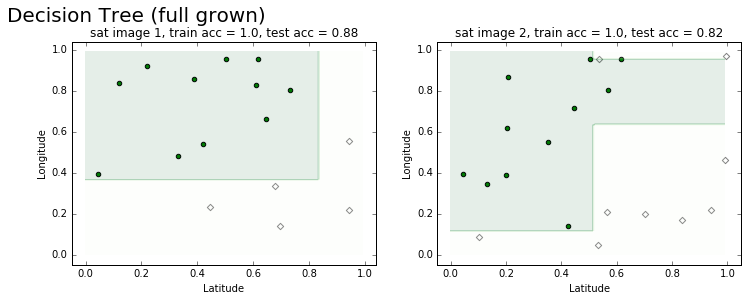

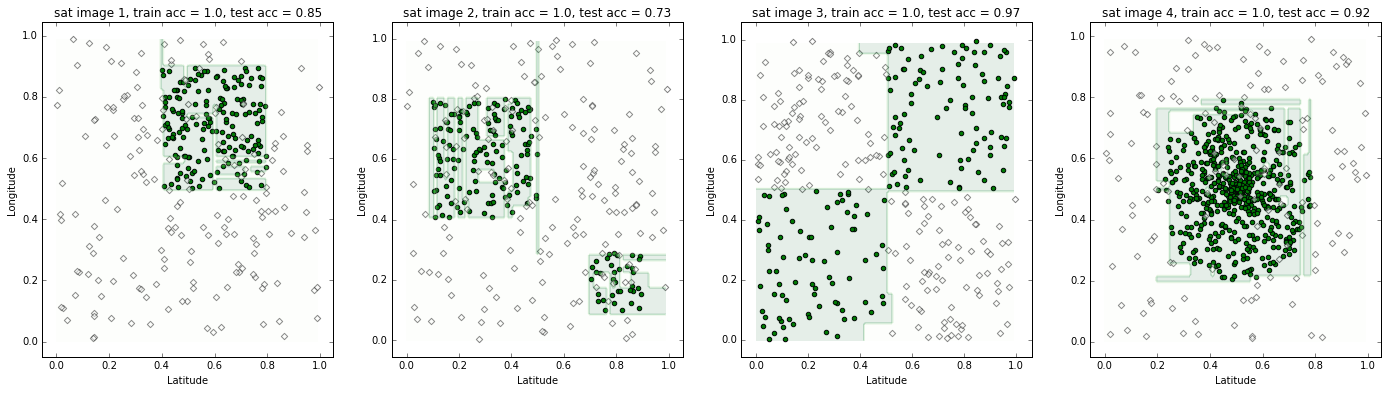

In [19]:
#Decision tree, only have x,y variables and tiny dataset, defaults should be fine
dt = tree.DecisionTreeClassifier()
boundary_plots_from_model(hw8_sat_images, dt, 'Decision Tree (full grown)')
boundary_plots_from_model(hw7_sat_images, dt, '')

plt.show()

#### Decision Trees
The decision tree models did fairly well, though, assuming there isn't any distortion in the decision boundary shading, a solid degree of overfitting appears to have hurt the final accuracy, not to say this could have been ameliorated by setting a branch limit. Especially in the 2nd image from HW7 we see extreme segmenting in and around the clusters that have the most vegetative coordinates. A simple decision tree has the advantage of being interpretable and explainable to a business audience but in order get further accuracy improvements via tree ensemble methods such as Random Forest, much of this will be lost. Similar in terms of computation required - a small amount for a single decision tree but of course significantly higher in an ensemble method that might involve creating thousands of trees. Some ensemble methods though, such as bagging, can be parallelized, so depending on the system architecture, computational requirements can be less of a concern, at least in terms of overall time required.


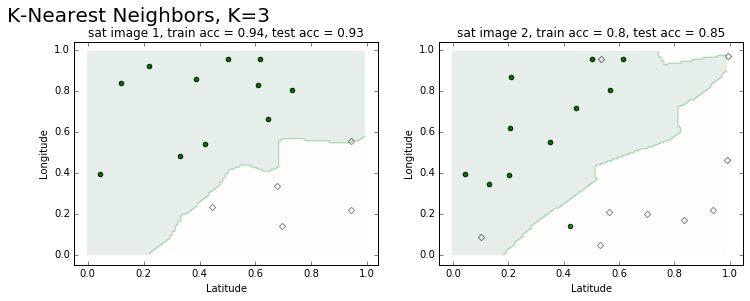

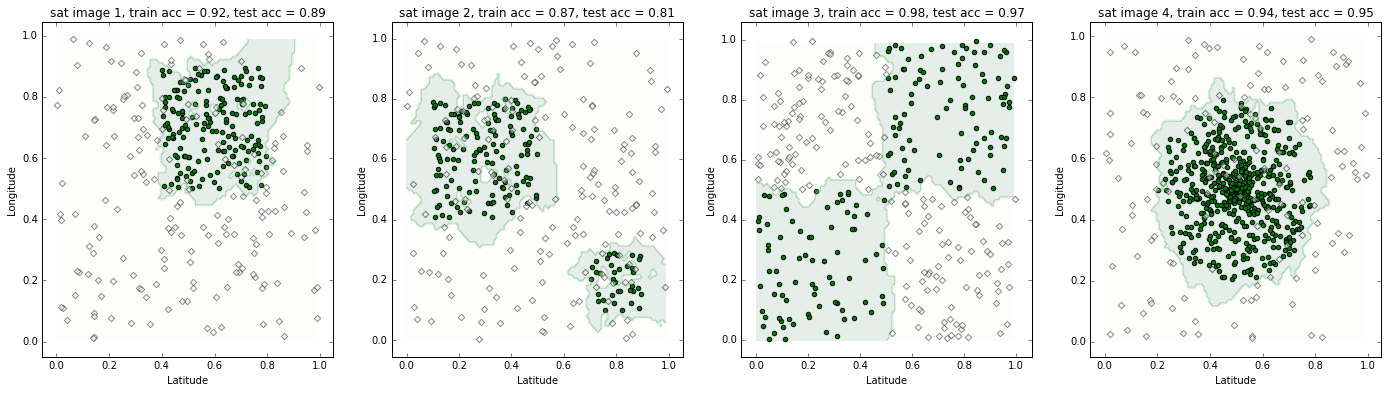

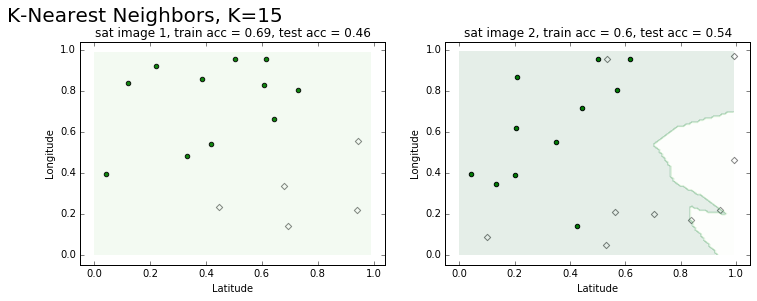

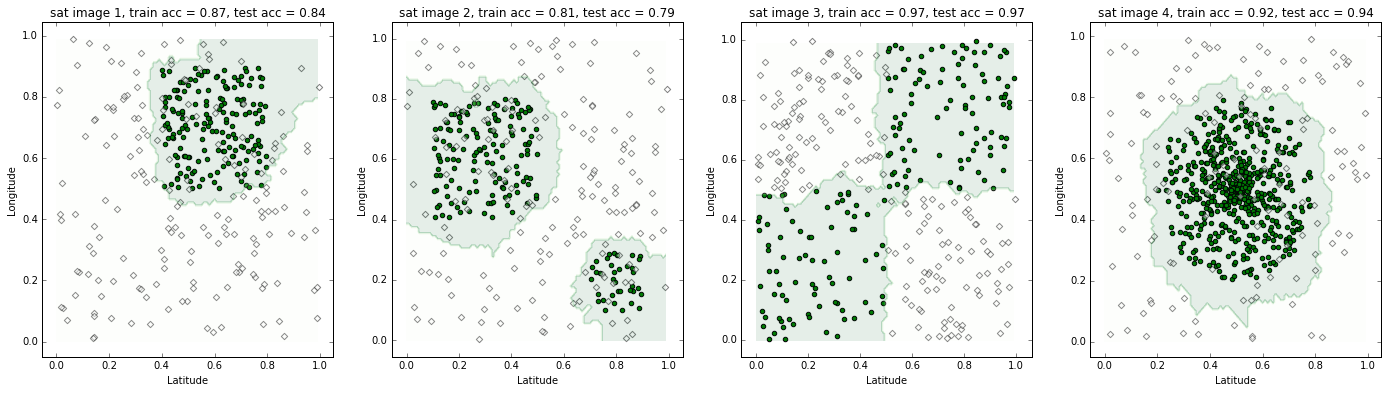

In [20]:
knn3 = knn.KNeighborsClassifier(3)
boundary_plots_from_model(hw8_sat_images, knn3, 'K-Nearest Neighbors, K=3')
boundary_plots_from_model(hw7_sat_images, knn3, '')

knn15=knn.KNeighborsClassifier(15)
boundary_plots_from_model(hw8_sat_images, knn15, 'K-Nearest Neighbors, K=15')
boundary_plots_from_model(hw7_sat_images, knn15, '')

plt.show()

#### K-Nearest Neighbor


In the above we see KNN with a low K doing well on the sparse datasets from this homework but then failing with an increased K - but that is because the training sets are so tiny that we are essentially telling it to look at all points in the dataset. The results on the HW7 images are much more promising and here is where we can see the potential of KNN. Specifically the as-drawn decision boundaries illustrate how this might be the best approach when there is great mixture of data. On the downside KNN tends to be rather computationally expensive and also has high storage needs in that you need the entire dataset to be able to persist the model. It does have good interpretability though, and a very simple and, in the K value, an explainable and flexible tuning parameter. K can also be adjusted when there are concerns about overfitting, by increasing the level of K.

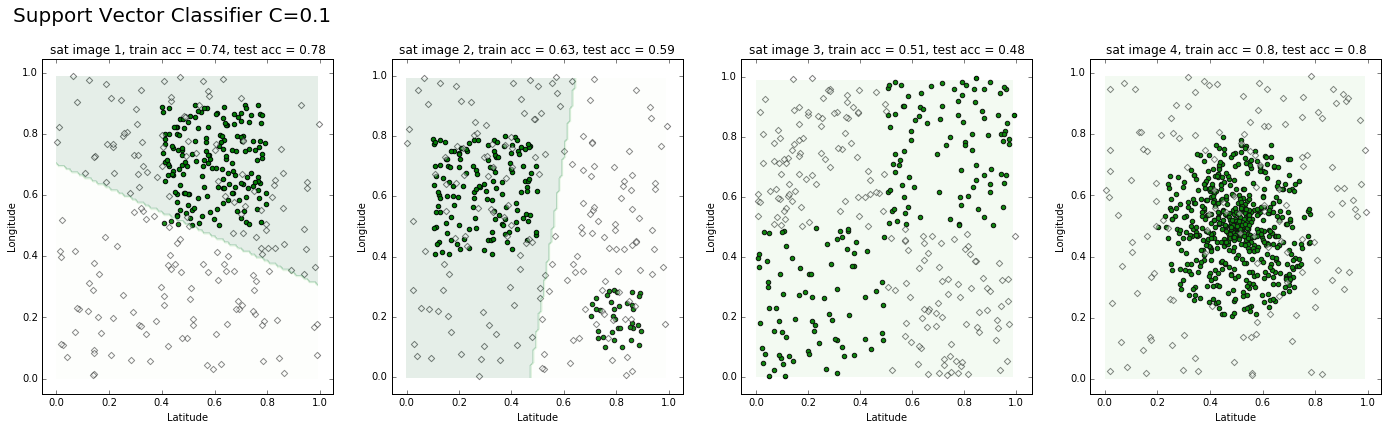

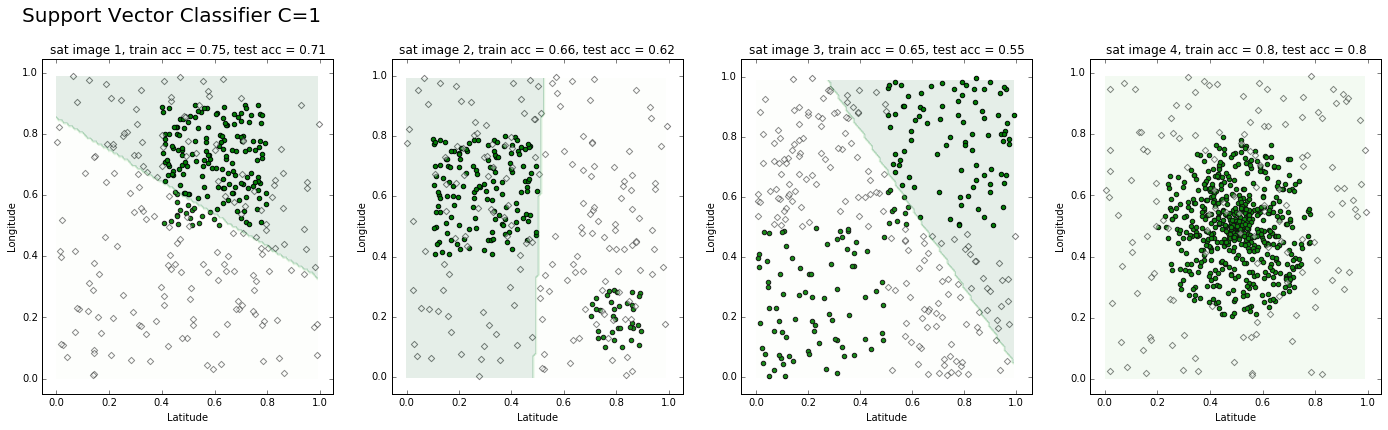

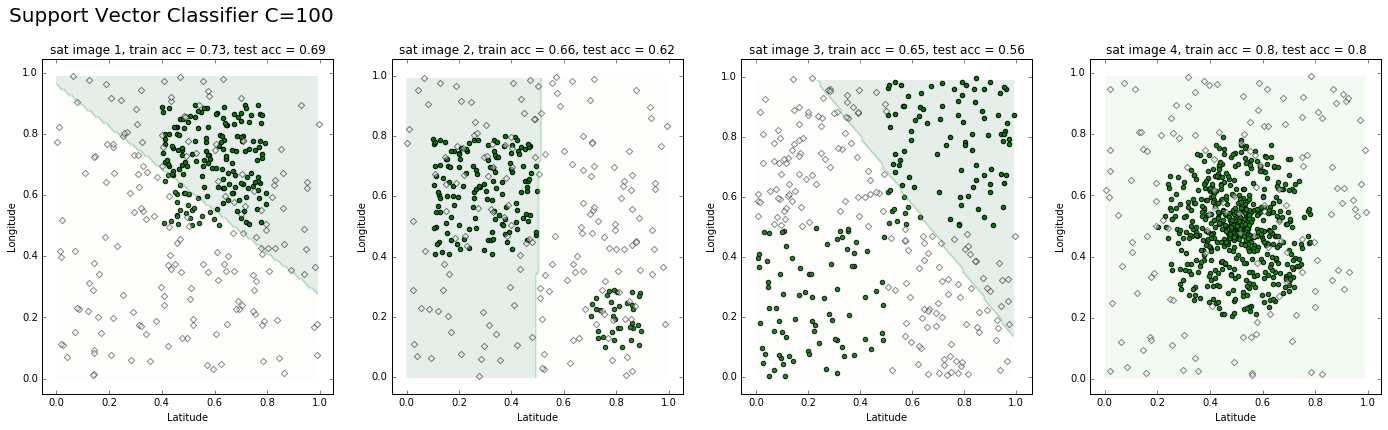

In [21]:
# now that we have the functions from hw7 in place, run those datasets through SVM and display with varying degrees of C

C = 1
for C in [0.1, 1, 100]:
    sv_m = svm.SVC(C=C, kernel='linear')
    boundary_plots_from_model(hw7_sat_images, sv_m, 'Support Vector Classifier C={}'.format(C))

plt.show()

The differing values of C in the above were more of a sanity check than anything - given the distributions in each of the HW7 datasets it didn't seem likely a) SVM was going to perform well, and b) that playing around with values of C would help out. Since my code was reasonably flexible, it was only a few lines to check out.  

And indeed Support Vector Classifier failed in each of above, though most flagrantly in the circular dataset (sat image 4), in which it decided to classify everything as vegetation. We did see success at the top of the notebook, for dataset 1, which I've formally added below, in the next cell. There we can see 100% accuracy w/C=100. If the data points weren't so intermixed SVM would have had better performance, it doesn't need perfect separation but it still needs to be able to draw a straight line that reasonably separates the two classes. A situation in which the majority of each classes points were far away from the boundary SVM classifier tries to draw, the better. Also interesting to note that the data points that are not near the maximal (soft) margin won't affect the model - they could be all clustered 90 degrees from the boundary, or 45 degrees, won't matter as long as they aren't support vectors. This aspect, which SVM classifiers generally share with logistic regression models, stands in contrast to LDA, which depends on the mean of all observations in a given class.

But in order to get SVM as a concept to perform well on the HW7 images it seems evident we would need to dip into "support vector machine" variant, as distinct from "support vector classifier" used in this HW. Since that model wasn't covered in class, I won't make any assumptions here. 

The SVM here though, at least has the benefit of needing minimal information to set the model, the support vectors themselves. As long as we can get away with a relatively low C, i.e. a low C provides adequate accuracy, computational needs shouldn't be too bad...ok, that's a guess, it doesn't strike me as being one of the quicker models given what it needs to do.

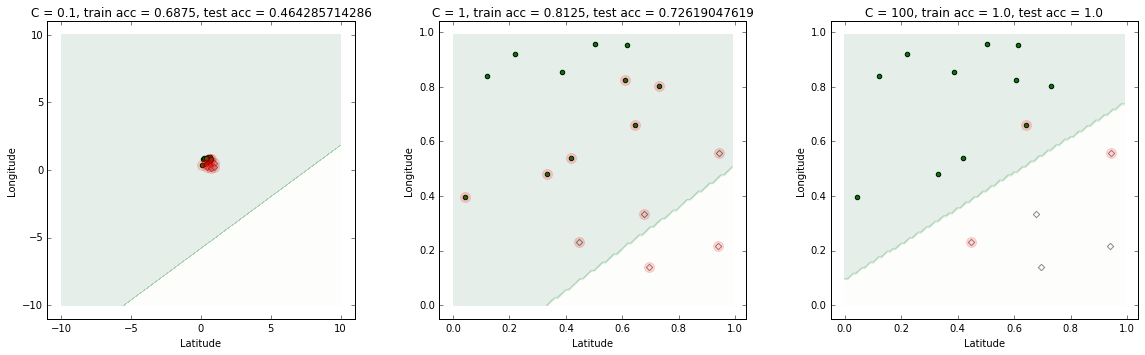

In [22]:
# since the initial dataset 1 decision boundaries had looked good, had earlier proceeded to examine the 2nd dataset 
# take a quick run through the dataset 1 to get some real test accuracy scores
x_train_1 = data_1_train.values[:, 0:-1]
y_train_1 = data_1_train.values[:, -1]

x_test_1 = data_1_test.values[:, 0:-1]
y_test_1 = data_1_test.values[:, -1]

# Fit and plot for different 'C' values
fig, ax = plt.subplots(1, 3, figsize = (16, 5))

ax[0] = fit_and_plot_svm_for_c(x_train_1, y_train_1, x_test_1, y_test_1, 0.1, ax[0], (-10, 10))
ax[1] = fit_and_plot_svm_for_c(x_train_1, y_train_1, x_test_1, y_test_1, 1, ax[1])
ax[2] = fit_and_plot_svm_for_c(x_train_1, y_train_1, x_test_1, y_test_1, 100, ax[2])

plt.tight_layout()

Problem 1 had also mentioned different types of images, such as handwritten digits. The number of variables is so huge in this scenario I'm not sure how it would be handled without processing via PCA. Perhaps KNN would hold out the best chance but the computational requirements would be potentially huge unless reduced enough via PCA. I'm not sure if the other model choices would be able to make the fine grained analysis necessary, once you begin looking at more than a few possible digits. Introduce the full alphabet and I'm guessing we are into territory that might be covered in 109b.

---

## Problem 2 (Optional): Classification Competition

This problem will involve an class-wide model building competition, where you will compete with each other in building a prediction model for cancer diagnosis. The results will be displayed live on a public leaderboard. The competition begins on Nov 9th, 3:00pm, and end on Nov 16th, 11:59pm. 

Please access the following link for all relevant details (data set, submission instructions, evaluation metric, leader board, etc.):
https://inclass.kaggle.com/c/harvard-data-science-course-competition

**Reward:** The top 20% of students on the leaderboard will each receive one bonus point to apply to an homework score of their choice (meaning you can turn a homework score of 2 to a 3, 3 to a 4, 5 to a 6 etc).

---

## Challenge Problem: Meta Learning

In the problem, you are provided with 10 different previously trained prediction models for a spam classification task. The task is to investigate how can one combine these models into a single meta classification model (without retraining the individual models) that performs better than each of the individual ones? 

The data for this problem is provided in the files `dataset_5_train.txt` and `dataset_5_test.txt`. Each row of these files is an email described by 57 attributes, and the last column is 1 if the email is spam, and 0 otherwise. 

The prediction models are provided in the file `models.npy` and can be loaded into an array by executing: 

`models = np.load('models.npy')`

As before, you can make predictions using the $i^\text{th}$ using:

`model[i].predict(x_test)` 

and score the model using:

`model[i].score(x_test, y_test)`

The baseline for this task is a simple combination strategy that takes a majority vote from the individual prediction models.

**Any reasonable model that performs better than the baseline model on the test set will receive full credit.**

There are many intuitive ways to combine these 10 models into one; a more sophisticated approach is called "mixture of experts". In this problem, we are not requiring you to implement any particular approach.

---